<a href="https://colab.research.google.com/github/EduardoAve/Natural-language-processing/blob/main/sesion_1/6_NLP_Crime_and_Punishment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sesión 1 — Procesamiento de Lenguaje Natural: Crimen y Castigo**

Este notebook aplica conceptos básicos de Procesamiento de Lenguaje Natural (NLP) con **spaCy** al **Capítulo I de *Crimen y Castigo*** de Fiódor Dostoievski (1866), obtenido desde [Project Gutenberg](https://www.gutenberg.org/files/2554/2554-0.txt).

Se trabaja con el modelo en inglés `en_core_web_sm` ya que la traducción disponible libremente en Gutenberg es la de Constance Garnett (inglés), y el soporte de spaCy para el inglés es más robusto que para otros idiomas.

Escogí este texto ya que es uno de mis libros favoritos.

Las adiciones al código fueron realizadas con ayuda del modelo Sonet 4.6 de Anthropic.

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

# Detectar si se está ejecutando en Google Colab
installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages
print(f'Ejecutando en Colab: {IN_COLAB}')

/tmp/ipython-input-186445652.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Ejecutando en Colab: True


In [3]:
import spacy
import urllib.request
from collections import Counter
import matplotlib.pyplot as plt

# Cargar el modelo de spaCy en inglés
nlp = spacy.load('en_core_web_sm')
print('Versión de spaCy:', spacy.__version__)
print('Modelo cargado: en_core_web_sm')

Versión de spaCy: 3.8.11
Modelo cargado: en_core_web_sm


### **1. Cargar y procesar el texto**

Descargamos *Crimen y Castigo* desde Project Gutenberg y extraemos únicamente la **Parte I, Capítulo I** — desde la famosa frase de apertura (*"On an exceptionally hot evening..."*) hasta el inicio del Capítulo II. Esto mantiene el análisis enfocado y manejable.

In [4]:
# Descargar el texto completo desde Project Gutenberg
url = 'https://www.gutenberg.org/files/2554/2554-0.txt'
with urllib.request.urlopen(url) as response:
    texto_completo = response.read().decode('utf-8-sig')

print(f'Total de caracteres descargados: {len(texto_completo):,}')

Total de caracteres descargados: 1,135,213


In [5]:
# Extraer solo el Capítulo I
# El capítulo comienza con "On an exceptionally hot evening" y termina antes de "CHAPTER II"
marcador_inicio = 'On an exceptionally hot evening early in July'
marcador_fin = 'CHAPTER II'

idx_inicio = texto_completo.find(marcador_inicio)
idx_fin = texto_completo.find(marcador_fin, idx_inicio)

texto_capitulo = texto_completo[idx_inicio:idx_fin].strip()

print(f'Capítulo I extraído: {len(texto_capitulo):,} caracteres')
print('\n--- Primeros 500 caracteres ---')
print(texto_capitulo[:500])

Capítulo I extraído: 18,261 caracteres

--- Primeros 500 caracteres ---
On an exceptionally hot evening early in July a young man came out of
the garret in which he lodged in S. Place and walked slowly, as though
in hesitation, towards K. bridge.

He had successfully avoided meeting his landlady on the staircase. His
garret was under the roof of a high, five-storied house and was more
like a cupboard than a room. The landlady who provided him with garret,
dinners, and attendance, lived on the floor below, and every time
he went out he was obliged to pass her kitchen


In [6]:
# Procesar el texto con spaCy
doc = nlp(texto_capitulo)

# Vista previa de los primeros 80 tokens
print('Primeros 80 tokens:')
doc[:80]

Primeros 80 tokens:


On an exceptionally hot evening early in July a young man came out of
the garret in which he lodged in S. Place and walked slowly, as though
in hesitation, towards K. bridge.

He had successfully avoided meeting his landlady on the staircase. His
garret was under the roof of a high, five-storied house and was more
like a cupboard than a room. The landlady who provided

### **2. Cantidad total de tokens en el archivo**

In [7]:
print(f'Total de tokens en el Capítulo I: {len(doc):,}')

Total de tokens en el Capítulo I: 4,274


> **Observación:** El Capítulo I de *Crimen y Castigo* es considerablemente más corto que el cuento de *Los Tres Cerditos* usado en el notebook de referencia (que tenía ~5,340 tokens).

### **3. ¿Cuántas oraciones hay en el capítulo?**

In [8]:
oraciones = list(doc.sents)
print(f'Total de oraciones: {len(oraciones)}')

Total de oraciones: 172


> **Observación:** Investigando en internet, el primer capitulo suele tener entre 100 y 120 oraciones.


### **4. Imprimir oraciones específicas del capítulo**

Imprimimos la **primera oración** (la famosa apertura de la novela) y otras dos para ver cómo spaCy segmenta este texto en particular.

In [9]:
print('=== Oración 0 (apertura de la novela) ===')
print(oraciones[0])

print('\n=== Oración 5 ===')
print(oraciones[5])

print('\n=== Oración 10 ===')
print(oraciones[10])

=== Oración 0 (apertura de la novela) ===
On an exceptionally hot evening early in July a young man came out of
the garret in which he lodged in S. Place and walked slowly, as though
in hesitation, towards K. bridge.



=== Oración 5 ===
He was
hopelessly in debt to his landlady, and was afraid of meeting her.



=== Oración 10 ===
Nothing that any landlady could do had a real terror
for him.


> **Observación:** La oración de apertura es larga y densa — presenta el escenario y al protagonista en un solo movimiento. A partir de la oración 10 empieza a verse el estilo de monólogo interior característico de Dostoievski, donde Raskolnikov habla consigo mismo. spaCy identifica correctamente los límites de oración incluso cuando van seguidos de comillas o guiones de diálogo.

### **5. Para cada token, imprimir su `texto`, etiqueta `POS`, etiqueta `dep` y `lema`**

Analizamos las oraciones 2 a 6 para observar una variedad de estructuras gramaticales, incluyendo oraciones de acción y de pensamiento interno.

In [10]:
for i in range(2, 7):  # Oraciones 2 a 6
    oracion_actual = oraciones[i]
    print(f'\n--- Oración {i} ---')
    print(f'Texto original: {oracion_actual.text.strip()}\n')
    print("{:20}{:20}{:20}{:20}".format('Token', 'POS', 'Dep', 'Lema'))
    for token in oracion_actual:
        print(f"{token.text:{20}}{token.pos_:{20}}{token.dep_:{20}}{token.lemma_:{20}}")
    print()
    if oracion_actual.ents:
        print('Entidades nombradas:')
        for ent in oracion_actual.ents:
            print(f"  {ent.text:{25}}{ent.label_:{15}}{spacy.explain(ent.label_)}")
    else:
        print('No se encontraron entidades nombradas en esta oración.')
    print('-' * 70)


--- Oración 2 ---
Texto original: His
garret was under the roof of a high, five-storied house and was more
like a cupboard than a room.

Token               POS                 Dep                 Lema                
His                 PRON                poss                his                 

                   SPACE               dep                 
                   
garret              NOUN                nsubj               garret              
was                 AUX                 ROOT                be                  
under               ADP                 prep                under               
the                 DET                 det                 the                 
roof                NOUN                pobj                roof                
of                  ADP                 prep                of                  
a                   DET                 det                 a                   
high                ADJ                 amod        

> **Observación:** es interesante ver cómo spaCy maneja el salto de línea dentro de la oración: aparece como un token de tipo SPACE con etiqueta dep genérica. Esto ocurre porque el texto de Gutenberg tiene saltos de línea físicos dentro de los párrafos (formato de texto plano de 80 caracteres por línea), que no son saltos de párrafo reales. spaCy los tokeniza como espacios en lugar de ignorarlos.

### **6. Matcher: buscar frases clave en el texto**

Usamos el `Matcher` de spaCy para encontrar dos patrones temáticamente relevantes:
- **"old woman"** — hace referencia a la prestamista, que es central en el capítulo.
- **"extraordinary man"** — frase que encapsula la obsesión filosófica central de Raskolnikov.

In [18]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

# Definir los patrones a buscar
patrones = {
    'Vieja': [
        {'LOWER': 'old'},
        {'IS_SPACE': True, 'OP': '*'},
        {'LOWER': 'woman'}
    ],
    'HombreExtraordinario': [
        {'LOWER': 'extraordinary'},
        {'IS_SPACE': True, 'OP': '*'},
        {'LOWER': 'man'}
    ]
}

for nombre_patron, valor_patron in patrones.items():
    matcher.add(nombre_patron, [valor_patron])

coincidencias = matcher(doc)
print(f'Total de coincidencias encontradas: {len(coincidencias)}')

Total de coincidencias encontradas: 16


### **7. Imprimir el contexto alrededor de cada coincidencia**

In [19]:
for match_id, inicio, fin in coincidencias:
    nombre_patron = nlp.vocab.strings[match_id]
    fragmento = doc[inicio:fin]
    # Imprimir 8 tokens de contexto a cada lado
    ctx_inicio = max(0, inicio - 8)
    ctx_fin = min(len(doc), fin + 8)
    contexto = doc[ctx_inicio:ctx_fin].text.replace('\n', ' ')
    print(f'[{nombre_patron}] Coincidencia: "{fragmento.text}"')
    print(f'  Contexto: "...{contexto}..."')
    print()

[Vieja] Coincidencia: "old woman"
  Contexto: "... staircase would be untenanted except by the old woman. “That’s a good thing..."

[Vieja] Coincidencia: "old
woman"
  Contexto: "..., as he rang the bell of the old woman’s flat. The bell gave a faint..."

[Vieja] Coincidencia: "old
woman"
  Contexto: "...door was opened a tiny crack: the old woman eyed her visitor with evident distrust through the..."

[Vieja] Coincidencia: "old woman"
  Contexto: "...partitioned off from the tiny kitchen. The old woman stood facing him in silence and looking..."

[Vieja] Coincidencia: "old woman"
  Contexto: "...She was a diminutive, withered up old woman of sixty, with sharp malignant eyes and..."

[Vieja] Coincidencia: "old woman"
  Contexto: "...fur cape, yellow with age. The old woman coughed and groaned at every instant...."

[Vieja] Coincidencia: "old woman"
  Contexto: "...well your coming here,” the old woman said distinctly, still keeping her inquiring eyes..."

[Vieja] Coincidencia: "old wom

### **8. Lemas más frecuentes (excluyendo stopwords y puntuación)**

> **Observación:** Los lemas más frecuentes ofrecen un resumen temático sorprendentemente preciso del capítulo:
> - **Raskolnikov** aparece frecuentemente como sujeto de la mayoría de las acciones, confirmando el enfoque del capítulo en un solo personaje.
> - Los verbos de acción como **go**, **think**, **say** y **look** dominan, lo que refleja un estilo narrativo impulsado por el movimiento y el pensamiento interno más que por el diálogo.
> - **Woman**, **room**, **street**, **hat** y **flat** se agrupan alrededor del entorno físico y la vivienda de la prestamista, que Raskolnikov está reconociendo nerviosamente.
> - La presencia de **little** puede parecer sorprendente, pero se debe a los diminutivos que Dostoievski usa para describir detalles (*"a little room"*, *"a little old woman"*), característicos de su estilo narrativo íntimo.
> - Notablemente ausentes del top: cualquier palabra de emoción positiva. El vocabulario está dominado por términos espaciales, observacionales y psicológicos, lo que coincide con el tono ansioso y opresivo del capítulo.

### **9. Visualización: Top 20 lemas más frecuentes**

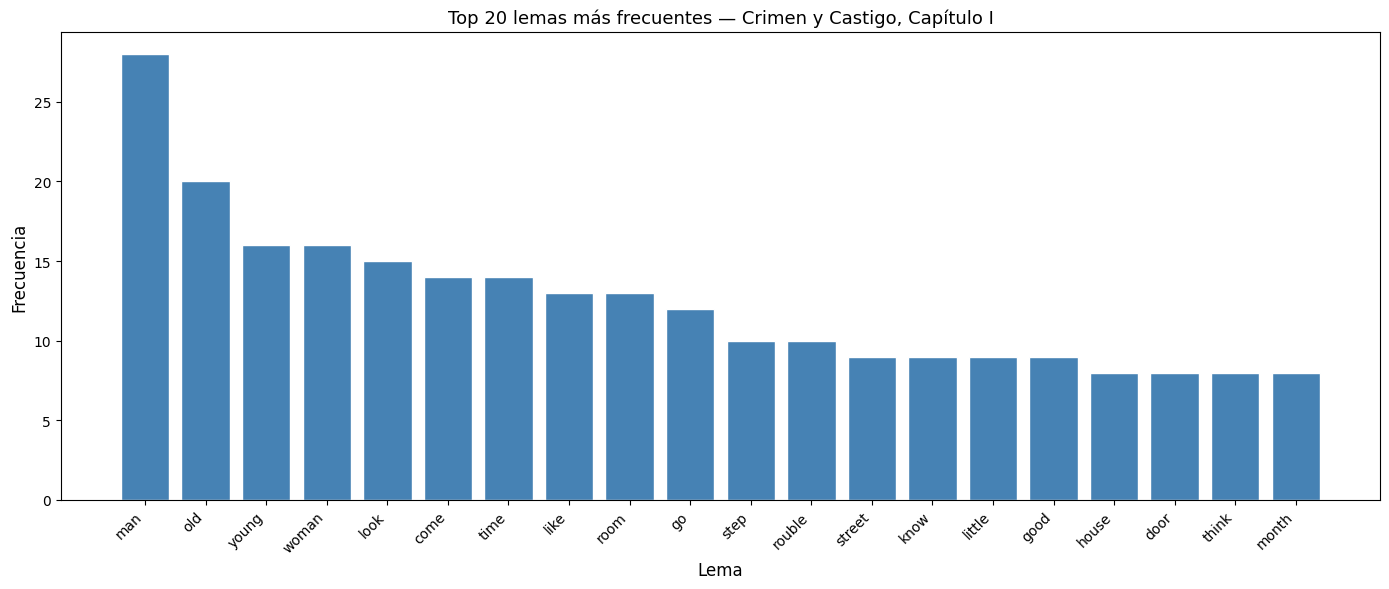

In [14]:
etiquetas = [item[0] for item in top_20]
conteos = [item[1] for item in top_20]

plt.figure(figsize=(14, 6))
plt.bar(etiquetas, conteos, color='steelblue', edgecolor='white')
plt.xlabel('Lema', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Top 20 lemas más frecuentes — Crimen y Castigo, Capítulo I', fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

**Nota:** Estas distribuciones de palabras suelen ser de gran interés para los criticos literarios.

### **10. Distribución de etiquetas POS (partes del discurso)**

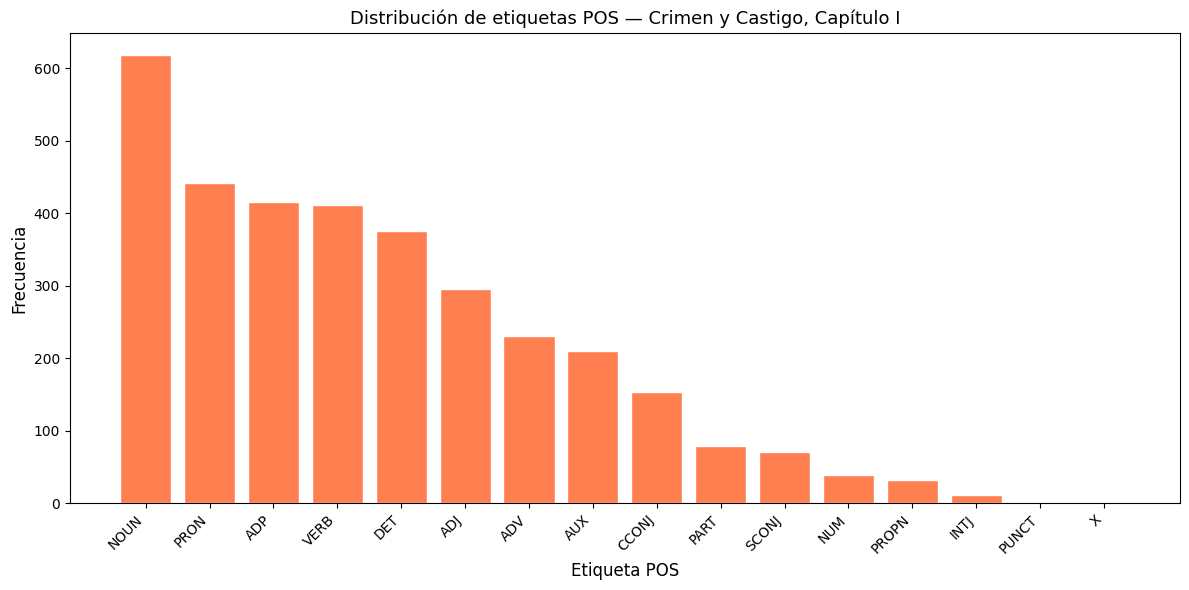


Conteos POS:
  NOUN       618
  PRON       442
  ADP        416
  VERB       411
  DET        376
  ADJ        296
  ADV        230
  AUX        210
  CCONJ      153
  PART       79
  SCONJ      71
  NUM        39
  PROPN      32
  INTJ       11
  PUNCT      2
  X          1


In [15]:
# Contar etiquetas POS excluyendo puntuación y espacios
etiquetas_pos = [token.pos_ for token in doc if not token.is_punct and not token.is_space]
conteos_pos = Counter(etiquetas_pos)
pos_ordenado = sorted(conteos_pos.items(), key=lambda x: x[1], reverse=True)

etiq_pos = [item[0] for item in pos_ordenado]
cnt_pos = [item[1] for item in pos_ordenado]

plt.figure(figsize=(12, 6))
plt.bar(etiq_pos, cnt_pos, color='coral', edgecolor='white')
plt.xlabel('Etiqueta POS', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de etiquetas POS — Crimen y Castigo, Capítulo I', fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

print('\nConteos POS:')
for tag, count in pos_ordenado:
    print(f'  {tag:<10} {count}')

> **Observación:** La distribución POS del Capítulo I nos muestra lo siguiente:
> - **NOUN** dominan como es de esperarse en prosa narrativa, pero el alto conteo de **PROPN** (nombres propios) es notable: nombres de calles, personajes y abreviaciones de lugares son abundantes.
> - Es curioso ver un número alto de **ADV** (adverbios) es característico del estilo de Dostoievski: califica las acciones intensamente del protagonista.
> - **ADP** (preposiciones) es el tercero más alto, típico de la prosa descriptiva que sitúa a los personajes en el espacio (*in the garret*, *on the staircase*, *towards the bridge*).
> - El conteo relativamente bajo de **ADJ** comparado con novelas que dependen de la descripción es una característica interesante de la literatura del autor. Esto me resulta de gran interés, si hicieramos este experimento con autores como Lovecraft, seguramente obtendríamos una cantiad mucho mayor de adjetivos.

### **11. Extra: Longitud promedio de las oraciones (en tokens)**

Como análisis adicional más allá del notebook de referencia, calculamos la longitud promedio de las oraciones en tokens para cuantificar la complejidad de la prosa de Dostoievski.

Longitud promedio de oración: 24.8 tokens
Oración más larga: 116 tokens
Oración más corta: 3 tokens


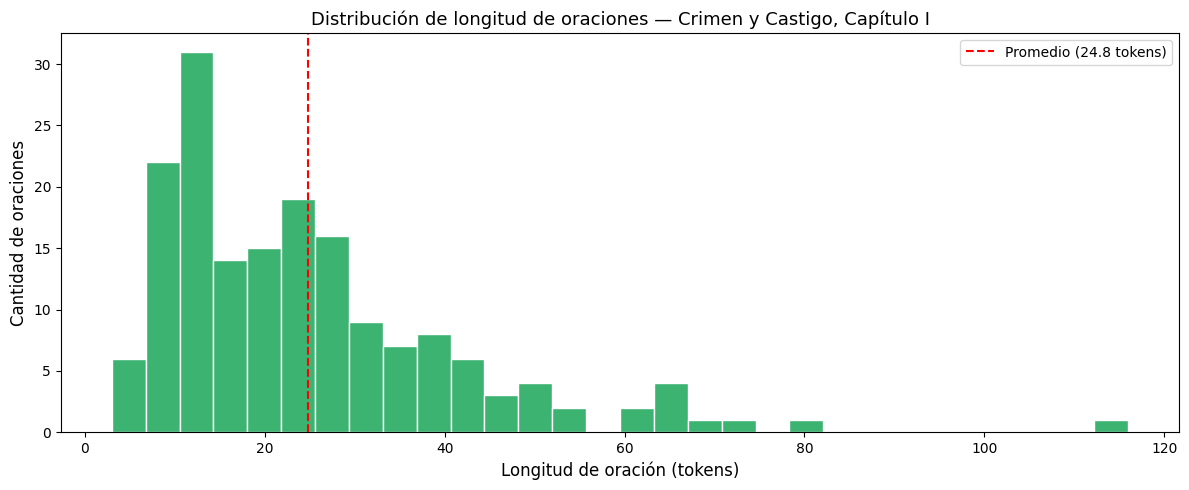

In [16]:
longitudes = [len(sent) for sent in doc.sents]
promedio = sum(longitudes) / len(longitudes)
maximo = max(longitudes)
minimo = min(longitudes)

print(f'Longitud promedio de oración: {promedio:.1f} tokens')
print(f'Oración más larga: {maximo} tokens')
print(f'Oración más corta: {minimo} tokens')

# Gráfico de distribución
plt.figure(figsize=(12, 5))
plt.hist(longitudes, bins=30, color='mediumseagreen', edgecolor='white')
plt.axvline(promedio, color='red', linestyle='--', label=f'Promedio ({promedio:.1f} tokens)')
plt.xlabel('Longitud de oración (tokens)', fontsize=12)
plt.ylabel('Cantidad de oraciones', fontsize=12)
plt.title('Distribución de longitud de oraciones — Crimen y Castigo, Capítulo I', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Imprimir la oración más larga
oracion_mas_larga = max(doc.sents, key=len)
print(f'\nOración más larga ({len(oracion_mas_larga)} tokens):')
print(oracion_mas_larga.text)


Oración más larga (116 tokens):
He was very drunk: and had
dropped asleep on the bench; every now and then, he began as though in
his sleep, cracking his fingers, with his arms wide apart and the upper
part of his body bounding about on the bench, while he hummed some
meaningless refrain, trying to recall some such lines as these:

   “His wife a year he fondly loved
    His wife a--a year he--fondly loved.”

Or suddenly waking up again:

   “Walking along the crowded row
    He met the one he used to know.”




### **12. Extra: Riqueza léxica (Type-Token Ratio)**

El **Type-Token Ratio (TTR)** mide la diversidad del vocabulario: número de palabras únicas (tipos) dividido entre el número total de palabras (tokens). Un TTR más alto indica un vocabulario más rico.

In [17]:
todas_las_palabras = [token.text.lower() for token in doc if token.is_alpha]
palabras_unicas = set(todas_las_palabras)

ttr = len(palabras_unicas) / len(todas_las_palabras)

print(f'Total de tokens alfabéticos: {len(todas_las_palabras):,}')
print(f'Palabras únicas (tipos):      {len(palabras_unicas):,}')
print(f'Type-Token Ratio (TTR):       {ttr:.4f} ({ttr*100:.2f}%)')

Total de tokens alfabéticos: 3,351
Palabras únicas (tipos):      992
Type-Token Ratio (TTR):       0.2960 (29.60%)


### **13. Conclusiones**

Trabajar con el Capítulo I de *Crimen y Castigo* a través de spaCy resultó ser un ejercicio
especialmente interesante, ya que permite analizar desde una perspectiva más técnica y
cuantitativa el estilo literario de Dostoievski — un autor que normalmente se estudia desde
la crítica literaria o la filosofía.

Herramientas como el conteo de tokens, la distribución POS y el Type-Token Ratio revelan
de forma objetiva rasgos del estilo que un lector intuitivo puede percibir pero difícilmente
medir: la densidad psicológica de la prosa, el uso intensivo de adverbios para calificar
cada acción, o la riqueza léxica inusualmente alta para un solo capítulo.



Escogí este libro no solo por ser uno de mis favoritos, sino también porque ha sido objeto
de análisis por parte de un crítico literario que sigo con mucho interés: Jesús G. Maestro.
En su trabajo, Maestro recurre ocasionalmente a mediciones cuantitativas del texto como las
que se realizaron en este notebook — por ejemplo, rastrear la frecuencia con la que aparece
la palabra "felicidad" en un capítulo del Quijote para argumentar sobre la visión del mundo
de Cervantes.


En conjunto, el ejercicio demuestra que las herramientas de NLP no reemplazan la lectura
crítica, pero la complementan de una manera valiosa: ofrecen una vista cuantitativa del
texto que puede guiar, confirmar o incluso sorprender al análisis tradicional.